In [1]:
import json
import praw
import datetime
from collections import defaultdict
import json
from tqdm import tqdm
from prawcore.exceptions import Forbidden
import matplotlib.pyplot as plt
import os
from typing import List
import time
import os
import json
import pandas as pd
from openpyxl import Workbook
import csv
import copy

# Focus on top 1000 in every community

We'll track all of their activity accross all reddit, without their musical community activity. <br>
In this step we'll gather all the activity itself


In [17]:
genres: List = ['indieheads', 'hiphopheads',
                'Metal', 'electronicmusic', 'classicalmusic']

In [10]:
def write_or_append_to_json_file(data_dict, file_path):
    file_size = 0
    if os.path.isfile(file_path):
        file_size = os.stat(file_path).st_size

    with open(file_path, 'ab') as fp:
        if file_size > 0:
            fp.seek(file_size - 2)
            fp.truncate()
            fp.write(b',')
        fp.write(json.dumps(data_dict).encode('utf-8'))

    fp.close()

In [11]:
def load_authors_that_are_not_in_intersection():
    """
    Loading the list of authors that are related to a single musical genres
    (out of our selected 5 genres) and not part of any intersection between genres
    """
    with open('data/non_intersection_authors.json', 'r') as file:
        top_commenters_by_community = json.load(file)

In [12]:

def authenticate_with_reddit(is_oauth=False):
    if is_oauth:
        return praw.Reddit(
            client_id='1LxqtJft3LM75yx2MgPqAA',
            client_secret='',
            user_agent='desktop:eliranse-musical-preferences-oauth:v1.0.0 (by /u/eliranse)',
            username='eliranse',
            password=''
        )
    else:
        return praw.Reddit(
            client_id='w7tYilptWAf8X_bSFgw1ew',
            client_secret='',
            user_agent='desktop:eliranse-musical-preferences:v1.0.0 (by /u/eliranse)',
        )


reddit = authenticate_with_reddit(true)


def fetch_user_activity(username):
    current_date = datetime.datetime.utcnow()
    one_year_ago = current_date - datetime.timedelta(days=900)
    subreddit_data = defaultdict(
        lambda: {"count": 0, "submissions": [], "comments": []})
    user = reddit.redditor(username)
    for submission in paginate_results(user.submissions.new, limit=None):
        if submission.created_utc < one_year_ago.timestamp():
            break
        subreddit_name = submission.subreddit.display_name
        subreddit_data[subreddit_name]["count"] += 1
        if submission.selftext:
            subreddit_data[subreddit_name]["submissions"].append({
                "title": submission.title,
                "body": submission.selftext,
                "domain": submission.domain,
                "date": submission.created_utc
            })

    for comment in paginate_results(user.comments.new, limit=None):
        if comment.created_utc < one_year_ago.timestamp():
            break
        subreddit_name = comment.subreddit.display_name
        subreddit_data[subreddit_name]["count"] += 1
        subreddit_data[subreddit_name]["comments"].append({
            "body": comment.body,
            "date": datetime.datetime.fromtimestamp(comment.created_utc).isoformat()
        })
    return subreddit_data


def paginate_results(fetch_function, limit=None):
    results = []
    last_item = None

    while True:
        if last_item is None:
            new_results = list(fetch_function(limit=limit))
        else:
            new_results = list(fetch_function(
                limit=limit, params={'after': last_item}))
        if not new_results:
            break
        results.extend(new_results)
        last_item = new_results[-1].name
    return results

In [13]:
def mark_community_as_done(community_name: str):
    try:
        with open('done_communities.json', 'r') as f:
            done_communities = json.load(f)
            done_communities.append(community_name)
    except FileNotFoundError:
        done_communities = []

    with open('done_communities.json', 'w') as f:
        json.dump(done_communities, f)
    return done_communities

In [82]:
def count_non_empty_user_activity_files_for_single_genre(community_name: str):
    folder_path = os.path.join(
        'data', 'detailed_filtered_data', community_name)
    non_empty_count = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and file_path.endswith('.json'):
            with open(file_path, 'r', encoding='utf-8') as file:
                try:
                    data = json.load(file)
                    if data:
                        non_empty_count += 1
                except json.JSONDecodeError:
                    print(f"Error loading JSON from file: {file_path}")
    return non_empty_count


def count_non_empty_user_files_for_all_genres():
    for genre in genres:
        print(
            f"The amount of non-empty user-activity files for {genre}: {count_json_files(genre)}")


count_non_empty_user_files_for_all_genres()

The amount of non-empty user-activity files for indieheads: 915
The amount of non-empty user-activity files for hiphopheads: 996
The amount of non-empty user-activity files for Metal: 996
The amount of non-empty user-activity files for electronicmusic: 971
The amount of non-empty user-activity files for classicalmusic: 1000


In [ ]:
def complete_user_activity_fetching_to_goal(desired_users_amount_per_genre = 1000)
    for genre in genres:
        goal = desired_users_amount_per_genre - count_json_files(genre)
        print(f"Working on genre: {genre}, goal is: {goal}")
        count = 0
        for username in tqdm(top_commenters_by_community[genre]):
            if count >= goal:
                break
            file_path = os.path.join(
                "data", "detailed_data", genre, f"{username}.json")
            if not os.path.isfile(file_path):
                try:
                    user_activity = fetch_user_activity(username)
                    if user_activity:
                        write_or_append_to_json_file(user_activity, file_path)
                        count += 1
                        print(f'success! count/goal: {count}/{goal}')
                except Exception as e:
                    continue
        done_communities = mark_community_as_done(genre)

complete_user_activity_fetching_to_goal()

### Cleanup (1)

Filter out posts withut body (title only)


In [37]:

def filter_out_empty_posts_from_all_users():
    for genre in genres:
        genre_path = os.path.join("data", "detailed_data", genre)
        for filename in os.listdir(genre_path):
            if filename.endswith('.json'):
                file_path = os.path.join(genre_path, filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    try:
                        data = json.load(file)
                        filtered_data = filter_out_empty_posts_from_single_user(
                            data)
                        new_file_path = os.path.join(
                            "data", "detailed_filtered_data", genre, filename)
                        with open(new_file_path, 'w') as json_file:
                            json.dump(filtered_data, json_file, indent=4)
                    except json.JSONDecodeError:
                        print(f"Error decoding JSON from file: {file_path}")


def filter_out_empty_posts_from_single_user(data: dict):
    result = copy.deepcopy(data)
    for subreddit in data.keys():
        removed = 0
        for i, post in enumerate(data.get(subreddit).get('submissions')):
            if not post.get("body"):
                try:
                    result[subreddit]["submissions"].pop(i - removed)
                    removed += 1
                except IndexError:
                    print('error!!!')
    return result


filter_out_empty_posts_from_all_users()

### Cleanup (2)

Filter out all the activity from music related subreddits, to reduce noise


In [67]:
banned_genres = ["trap", "OutlawCountry", "Ska", "SoundsVintage", "indie_rock", "MelodicDeathMetal", "PsychedelicRock", "Deathcore", "GarageRock", "KoreanRock", "Noisey", "PopHeads", "Punk_Rock", "Synthpop", "ClassicRock", "Grime", "MetalMemes", "MusicTheory", "EmoRevival", "PunkRockers", "AlternativeRock", "ElectronicJazz", "Bluegrass", "ChristianMusic", "PsychRock", "DeathMetal", "Rockabilly", "Kpopthoughts", "HipHopCollabs", "RocknRoll", "ElectroBlues", "Djent", "Trance", "SwingMusic", "hiphopheads HOF", "FolkPunk", "PopRock", "PopPunk", "EmoScreamo", "MelodicMetalcore", "Rockband", "Chiptunes", "Albums", "NewWave", "IndieElectronica", "Metallica", "Psybient", "ProtestTheHero",
                 "EmoForever", "PopPunkEmo", "hiphopheads", "EDM", "rock", "metal", "popheads", "country", "punk", "indieheads", "rnbheads", "electronicmusic", "ClassicalMusic", "hiphop101", "alternativerock", "techno", "jazz", "kpop", "Blues", "Musicthemetime", "Soulies", "reggae", "MusicAlbums", "Emo", "GratefulDead", "PostHardcore", "PowerMetal", "hiphoptruth", "futurebeats", "progrockmusic", "Vaporwave", "musicals", "synthwave", "hiphop101", "Metalcore", "PopPunkers", "Dubstep", "IndieFolk", "psytrance", "hiphopimages", "lofihiphop", "OutRun", "industrialmusic", "IndieWok", "Coffeeshopvibes", "Electrohouse", "stonerrock", "swinghouse", "hiphophub", "SymphonicMetal", "Emo_irl", "progmetal",
                 "electronicmusic", "Jazz", "classical_circlejerk", "Baroque", "Mozart", "Chopin", "DnB", "Techno", "skrillex", "dubstep", "deephouse", "KendrickLamar", "Kanye", "Hiphopcirclejerk", "Eminem", "MacMiller", "HipHopGoneWild", "HipHopShit", "indieheadscirclejerk", "radiohead", "arcticmonkeys", "Kanye", "beatles", "TaylorSwift", "TheKillers", "RedHotChiliPeppers", "gorillaz", "Jazz", "lorde", "blur", "TheCure", "radioheadcirclejerk", "gratefuldead", "beatlescirclejerk", "Muse", "Blink182DavidBowieMegadeth", "BlackMetalMemes", "pinkfloyd", "Coldplayrem", "DaftPunk", "BlackMetal", "MetalPorn"]


def filter_out_banned_genres_from_all_users():
    for genre in genres:
        genre_path = os.path.join("data", "detailed_filtered_data", genre)
        for filename in os.listdir(genre_path):
            if filename.endswith('.json'):
                file_path = os.path.join(genre_path, filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    try:
                        data = json.load(file)
                        filtered_data = filter_out_banned_genres_from_single_user(
                            data)
                        new_file_path = os.path.join(
                            "data", "detailed_filtered_genre_data", genre, filename)
                        with open(new_file_path, 'w') as json_file:
                            json.dump(filtered_data, json_file, indent=4)
                    except json.JSONDecodeError:
                        print(f"Error decoding JSON from file: {file_path}")


def filter_out_banned_genres_from_single_user(data: dict):
    result = copy.deepcopy(data)
    for subreddit in data.keys():
        if subreddit in banned_genres:
            result.pop(subreddit)
    return result


filter_out_banned_genres_from_all_users()

### Representation, tabeles and insights

Excel and CSV Tables: <br>

- `redditors_activity_summary_filtered.csv`<br>
  All the detailed activity that we collected is listed by users. Every user's top 10 subreddits are listed with the amount of comments and non-empty posts
- `community_summary_filtered.xlsx`<br>
  Every musical genre (5) got its own spreadsheet and lists counters of it's fans' activity in other subreddits (comments and non-empty posts). When discovered music-related subreddits via this lists, we marked those as banned.


In [68]:
def generate_redditors_activity_summary_csv():
    main_folder_path = os.path.join("data", "detailed_filtered_data")
    header = ['musical_genre_community', 'username', 'subreddit 1 name', 'subreddit 1 count',
              'subreddit 2 name', 'subreddit 2 count', 'subreddit 3 name', 'subreddit 3 count',
              'subreddit 4 name', 'subreddit 4 count', 'subreddit 5 name', 'subreddit 5 count',
              'subreddit 6 name', 'subreddit 6 count', 'subreddit 7 name', 'subreddit 7 count',
              'subreddit 8 name', 'subreddit 8 count', 'subreddit 9 name', 'subreddit 9 count',
              'subreddit 10 name', 'subreddit 10 count']
    data_rows = []

    for genre_folder in os.listdir(main_folder_path):
        genre_folder_path = os.path.join(main_folder_path, genre_folder)
        if genre_folder.startswith('.'):
            continue

        for filename in os.listdir(genre_folder_path):
            file_path = os.path.join(genre_folder_path, filename)
            if filename.startswith('.'):
                continue

            username = os.path.splitext(filename)[0]
            with open(file_path, 'r') as json_file:
                json_data = json.load(json_file)

            if not json_data:
                continue

            subreddit_data = json_data.keys()
            subreddit_data = [
                subreddit for subreddit in subreddit_data if subreddit != genre_folder]
            sorted_subreddits = sorted(
                subreddit_data, key=lambda x: json_data[x]['count'], reverse=True)
            top_subreddits = sorted_subreddits[:10]

            row = [genre_folder, username]
            for subreddit in top_subreddits:
                row.append(subreddit)
                row.append(json_data[subreddit]['count'])

            data_rows.append(row)

    csv_path = os.path.join(
        "analysis", "redditors_activity_summary_filtered.csv")
    with open(csv_path, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(header)
        writer.writerows(data_rows)


generate_redditors_activity_summary_csv()

In [69]:
def generate_community_summary_excel_file()
    main_folder_path = os.path.join("data", "detailed_filtered_data")
    community_data = {}

    for genre_folder in os.listdir(main_folder_path):
        genre_folder_path = os.path.join(main_folder_path, genre_folder)
        if genre_folder.startswith('.'):
            continue
        subreddit_counts = {}

        for filename in os.listdir(genre_folder_path):
            file_path = os.path.join(genre_folder_path, filename)
            if filename.startswith('.'):
                continue
            with open(file_path, 'r') as json_file:
                json_data = json.load(json_file)

            subreddit_data = json_data.keys()
            subreddit_data = [
                subreddit for subreddit in subreddit_data if subreddit != genre_folder]
            for subreddit in subreddit_data:
                count = json_data[subreddit]['count']
                if count >= 1:
                    subreddit_counts[subreddit] = subreddit_counts.get(
                        subreddit, 0) + 1

        sorted_counts = sorted(subreddit_counts.items(),
                            key=lambda x: x[1], reverse=True)
        community_data[genre_folder] = sorted_counts

    workbook = Workbook()
    for community, subreddit_counts in community_data.items():
        df = pd.DataFrame(subreddit_counts, columns=[
                        'Subreddit', 'Number of Users'])
        sheet = workbook.create_sheet(title=community)
        sheet.append(['Subreddit', 'Number of Users'])
        for row in df.itertuples(index=False):
            sheet.append(row)
    workbook.remove(workbook['Sheet'])
    output_file_path = os.path.join('analysis', 'community_summary_filtered.xlsx')
    workbook.save(output_file_path)

generate_community_summary_excel_file()

### Graphical visualization

Based on the tables created above: <br>
Top subreddits among musical genres' fans: the number is the count of users that commented or posted at least once in a subreddit


Top subreddits - the number is the count of users that commented or posted at least once in a subreddit


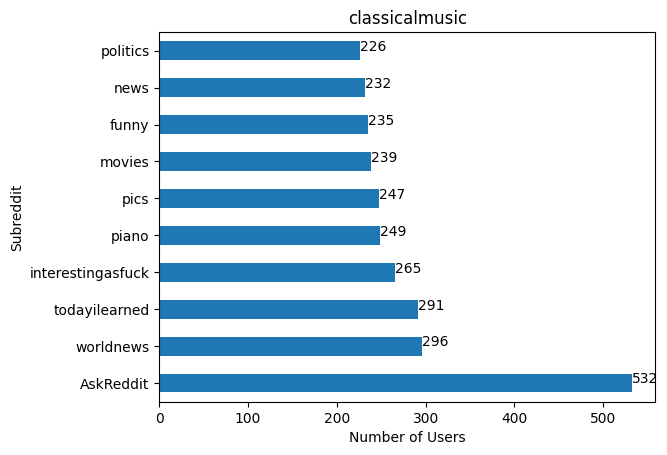

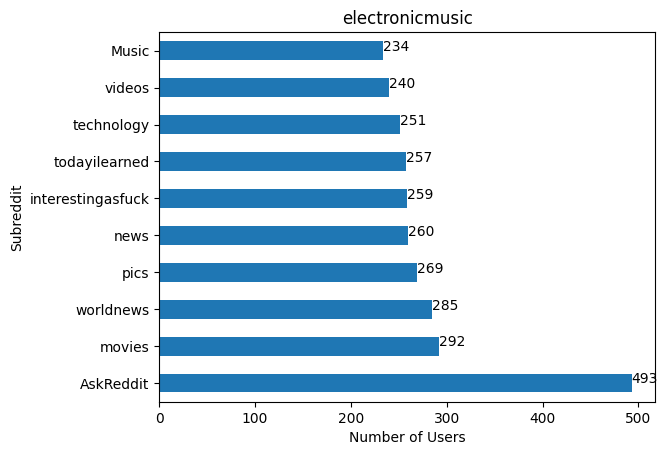

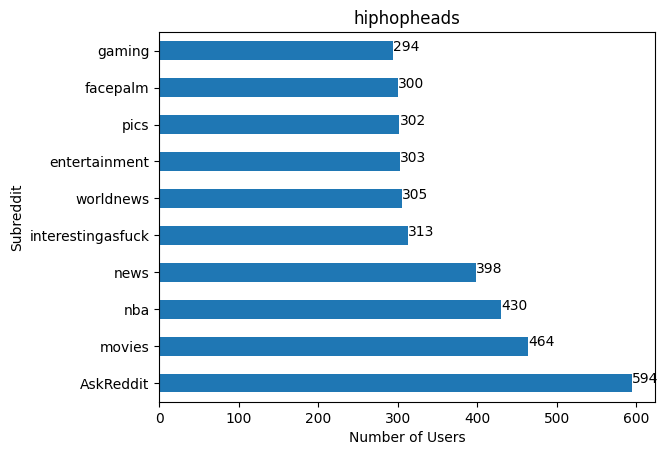

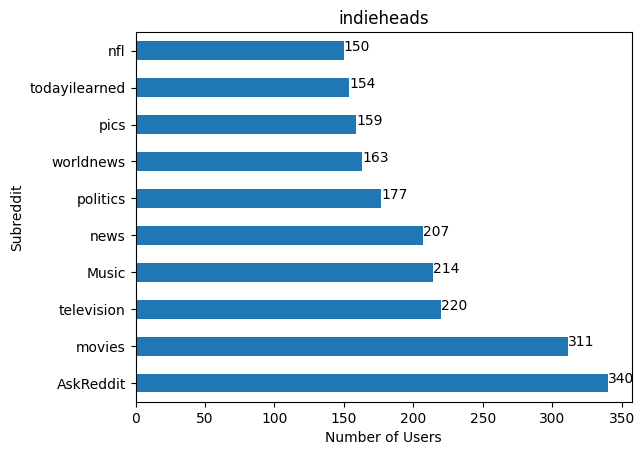

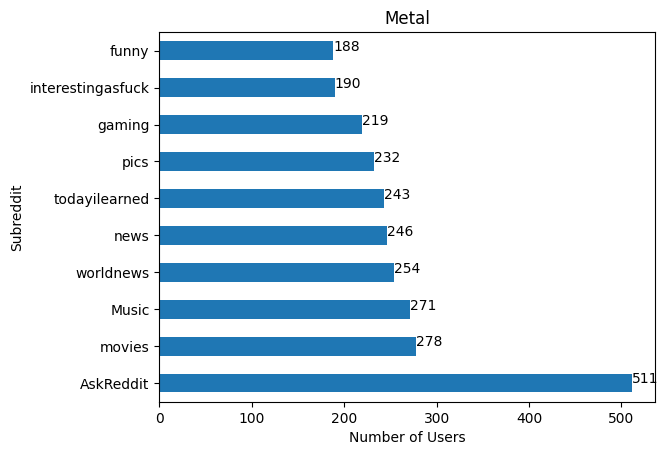

In [74]:
print('Top subreddits - the number is the count of users that commented or posted at least once in a subreddit')
xlsx_file = 'analysis/community_summary_filtered.xlsx'
xl = pd.ExcelFile(xlsx_file)
max_subreddits = 10

for sheet_name in xl.sheet_names:
    df = xl.parse(sheet_name)
    df.sort_values(by='Number of Users', ascending=False, inplace=True)
    top_subreddits = df.head(max_subreddits)
    top_subreddits.set_index('Subreddit', inplace=True)
    ax = top_subreddits.plot(kind='barh', legend=False)
    ax.set_xlabel('Number of Users')
    ax.set_ylabel('Subreddit')
    ax.set_title(sheet_name)
    for i, value in enumerate(top_subreddits['Number of Users']):
        ax.text(value, i, str(value))

    plt.show()

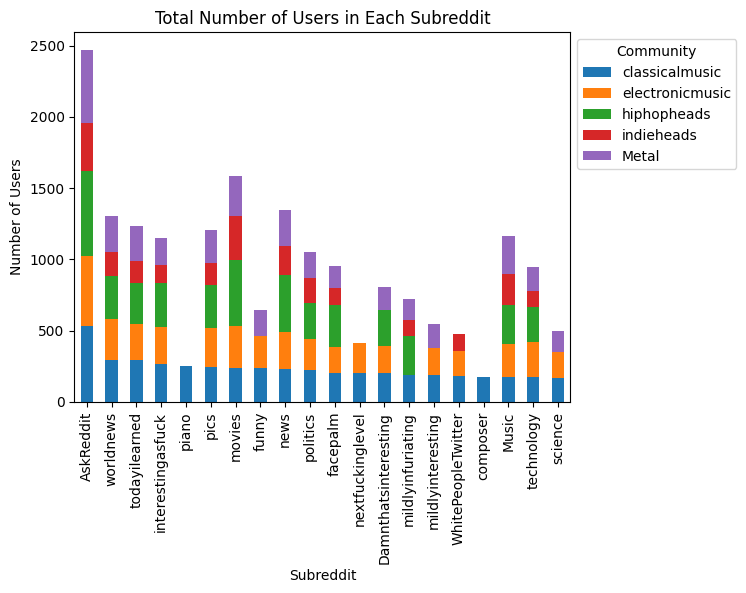

In [75]:
xlsx_file = 'analysis/community_summary_filtered.xlsx'
xl = pd.ExcelFile(xlsx_file)

max_subreddits = 20
data = pd.DataFrame()

for sheet_name in xl.sheet_names:
    df = xl.parse(sheet_name)
    df.sort_values(by='Number of Users', ascending=False, inplace=True)
    top_subreddits = df.head(max_subreddits)
    data[sheet_name] = top_subreddits.set_index('Subreddit')['Number of Users']

ax = data.plot(kind='bar', stacked=True)
ax.set_xlabel('Subreddit')
ax.set_ylabel('Number of Users')
ax.set_title('Total Number of Users in Each Subreddit')
ax.legend(title='Community', bbox_to_anchor=(1, 1), loc='upper left')

plt.show()